In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter

import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

import tensorflow as tf

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Trabajo previo en los datos

In [2]:
train_directory = "Dataset/train"
validation_directory = "Dataset/valid"

In [3]:
def cargar_imagenes_y_etiquetas(directorio):
    imagenes = []
    etiquetas = []
    etiquetas_indices = {}
    indice_actual = 0
    
    for root, _, files in os.walk(directorio):
        for file in files:
            # Verificar si el archivo es una imagen
            if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
                # Obtener la ruta completa de la imagen
                imagen_path = os.path.join(root, file)
                # El nombre del directorio padre es la etiqueta (Y)
                etiqueta = os.path.basename(root)
                
                # Si la etiqueta aún no está en el diccionario de índices, agregarla
                if etiqueta not in etiquetas_indices:
                    etiquetas_indices[etiqueta] = indice_actual
                    indice_actual += 1
                
                # Cargar la imagen
                imagen = cv2.imread(imagen_path)  
                
                imagenes.append(imagen)
                etiquetas.append(etiqueta)
    
    # Devolver las imágenes, las etiquetas y el diccionario de índices de etiquetas
    return imagenes, etiquetas, etiquetas_indices


X_train, y_train, y_train_index = cargar_imagenes_y_etiquetas(train_directory)

X_val, y_val, y_val_index = cargar_imagenes_y_etiquetas(validation_directory)

print("Ejemplos de imágenes y etiquetas de entrenamiento:")
print(f"Imagen: {X_train[1][1][:3]}..., Etiqueta: {y_train[1]}, Índice de la clase: {y_train_index.get(y_train[1])}")

print("\nEjemplos de imágenes y etiquetas de validación:")
print(f"Imagen: {X_val[1][1][:3]}..., Etiqueta: {y_val[1]}, Índice de la clase: {y_val_index.get(y_train[1])}")

Ejemplos de imágenes y etiquetas de entrenamiento:
Imagen: [[1 0 2]
 [0 0 1]
 [2 0 4]]..., Etiqueta: 88 AN, Índice de la clase: 0

Ejemplos de imágenes y etiquetas de validación:
Imagen: [[ 0 39 26]
 [ 0 40 27]
 [ 0 40 27]]..., Etiqueta: 88 AN, Índice de la clase: 0


In [4]:
def contar_imagenes_por_clase(etiquetas):
    conteo = Counter(etiquetas)
    return conteo

# Calcular el recuento de imágenes por clase en el conjunto de entrenamiento y validación
count_train = contar_imagenes_por_clase(y_train)
count_validation = contar_imagenes_por_clase(y_val)

df_count_train = pd.DataFrame(list(count_train.items()), columns=['Clase', 'Total de imágenes'])
df_count_validation = pd.DataFrame(list(count_validation.items()), columns=['Clase', 'Total de imágenes'])

df_count_train.to_excel('Recursos/Recuentro Entrenamiento.xlsx', index=False)
df_count_validation.to_excel('Recursos/Recuento Validación.xlsx', index=False)

Revisando manualmente los datos en excel, me encuentro conque la clase menos popular es la crimson patch, con 96 imágenes. Y la clase más popular tiene 184 imágenes, esta corresponde a Cloak Mourning, tendremos en cuenta estos puntos para la revisión de las métricas del modelo, y ver cómo predice cada una.

Dicho esto, procedemos a normalizar las imágenes:

In [5]:
X_train = np.array(X_train)
X_val = np.array(X_val)

print("Antes de la normalización: " + str(X_train[1][1][:3]))
print("Antes de la normalización: " + str(X_val[1][1][:3]))

X_train = X_train / 255.0
X_val = X_val / 255.0

print("Después de la normalización: " + str(X_train[1][1][:3]))
print("Después de la normalización: " + str(X_val[1][1][:3]))

Antes de la normalización: [[1 0 2]
 [0 0 1]
 [2 0 4]]
Antes de la normalización: [[ 0 39 26]
 [ 0 40 27]
 [ 0 40 27]]
Después de la normalización: [[0.00392157 0.         0.00784314]
 [0.         0.         0.00392157]
 [0.00784314 0.         0.01568627]]
Después de la normalización: [[0.         0.15294118 0.10196078]
 [0.         0.15686275 0.10588235]
 [0.         0.15686275 0.10588235]]


In [6]:
print("Datos de training, X e Y respectivamente: " + str(len(X_train)), ", " + str(len(y_train)))
print("Datos de validación, X e Y respectivamente: " + str(len(X_val)), ", " + str(len(y_val)))

Datos de training, X e Y respectivamente: 9092 , 9092
Datos de validación, X e Y respectivamente: 1949 , 1949


# Creación del modelo.

In [7]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Asignación de hiperparámetros.

In [8]:
epochs=100
img_rows,img_cols=180, 180 # Todas las imágenes vienen redimensionadas a 180x180 píxeles
input_shape=(img_rows,img_cols,3)
patience_factor = 3     

## Propuesta 1

In [62]:
model = keras.Sequential([
  Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=input_shape, activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(128, kernel_size=(3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(256, kernel_size=(3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.45),
  Dense(len(y_train_index), activation='softmax')
])   

## Propuesta 2

In [8]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(len(y_train_index), activation='softmax')
])

c:\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Propuesta 3

In [57]:
model = keras.Sequential([
  Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=input_shape, activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(64, kernel_size=(3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(128, kernel_size=(3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(256, kernel_size=(3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.45),
  Flatten(),
  Dense(150, activation='relu'),
  Dropout(0.45),
  Dense(len(y_train_index), activation='softmax')
])  

In [66]:
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 15:
        return 0.0001
    else:
        return 0.00001

In [67]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=patience_factor, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule)

In [60]:
y_one_hot_train = []
for etiqueta in y_train:
    y_one_hot_train.append(y_train_index[etiqueta])

y_one_hot_val= []
for etiqueta in y_val:
    y_one_hot_val.append(y_val_index[etiqueta])

# Una vez llenamos dos arrays con los índices de las etiquetas de las imágenes, utilizamos el metodo to_categorical()
# para convertirlo en un one-hot encoder, que se vería de la siguiente forma para la primera clase, ej: [1, 0, 0, 0...]

y_one_hot_train = to_categorical(y_one_hot_train)

y_one_hot_val = to_categorical(y_one_hot_val)

Ejemplo de cómo se ven los onehot encoders

In [13]:
print(y_one_hot_train)
print(len(y_one_hot_train))

print(y_one_hot_val)
print(len(y_one_hot_val))

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
9092
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
1949


In [ ]:
history = model.fit(X_train, y_one_hot_train, 
                    epochs=epochs, 
                    batch_size=32, 
                    validation_data=(X_val, y_one_hot_val), 
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler])

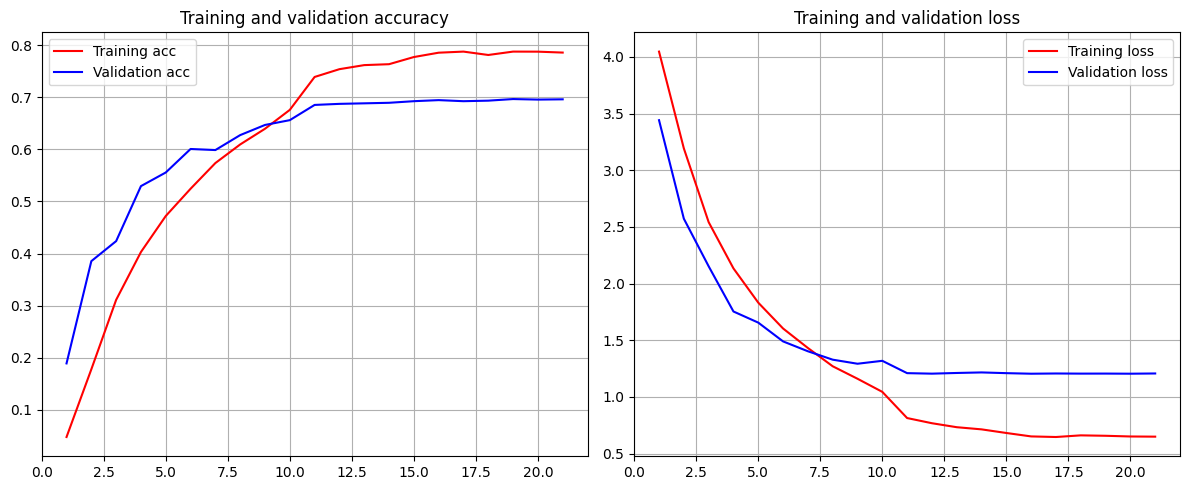

In [52]:
visualize(history)

## Entrenamiento con transfer learning

In [9]:
img_height,img_width=180,180
batch_size=32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_directory,
  seed=111,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  validation_directory,
  shuffle=False,
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9092 files belonging to 75 classes.
Found 1949 files belonging to 75 classes.


In [10]:
model = Sequential()

base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=input_shape,
                   pooling='avg',classes=75,
                   weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [11]:
for layer in base_model.layers:
        layer.trainable=False

In [12]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(75, activation='softmax'))

In [13]:
def lr_schedule(epoch):
    if epoch < 3:
        return 0.0005
    else:
        return 0.0001

In [14]:
# model.compile(optimizer=Adam(learning_rate=0.0001),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=patience_factor, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_resnet.keras', monitor='val_loss', save_best_only=True, verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule)

In [15]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
                   )

Epoch 1/10


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.1501 - loss: 3.7500
Epoch 1: val_loss improved from inf to 1.38688, saving model to best_model_resnet.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 287s 991ms/step - accuracy: 0.1506 - loss: 3.7474 - val_accuracy: 0.6747 - val_loss: 1.3869 - learning_rate: 5.0000e-04
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.5571 - loss: 1.6569
Epoch 2: val_loss improved from 1.38688 to 0.89281, saving model to best_model_resnet.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 275s 967ms/step - accuracy: 0.5573 - loss: 1.6563 - val_accuracy: 0.7671 - val_loss: 0.8928 - learning_rate: 5.0000e-04
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.6861 - loss: 1.1108
Epoch 3: val_loss improved from 0.89281 to 0.73314, saving model to best_model_resnet.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.6861 - loss: 1.1106 - val_accuracy: 0.8091 - val_loss: 0.7331 - learning_rate: 5.0000e-04
Epoch 4/10
285/285 ━━━━━━━━━━━━

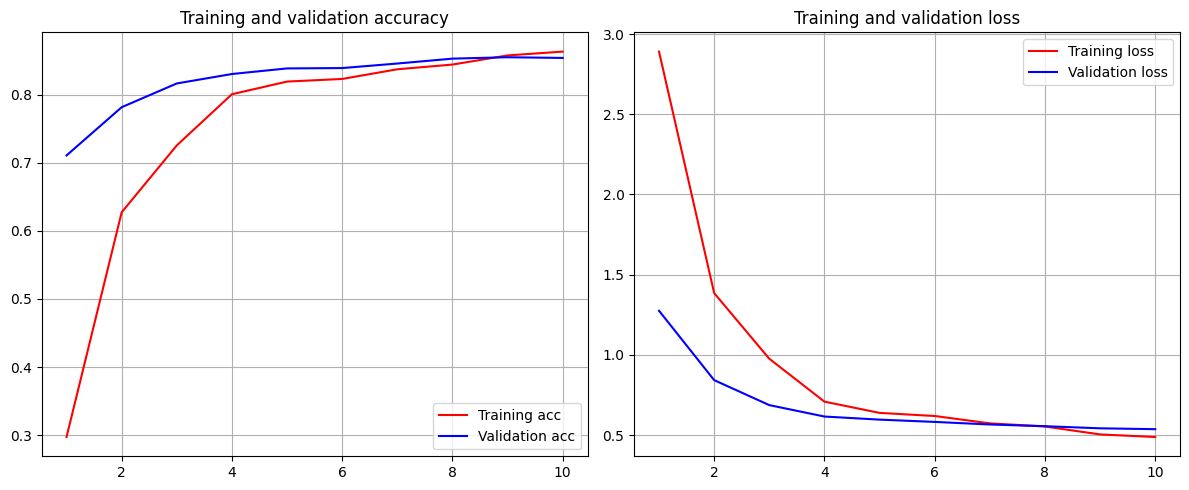

In [15]:
visualize(history)

In [25]:
y_pred = model.predict(val_dataset)

61/61 ━━━━━━━━━━━━━━━━━━━━ 51s 820ms/step


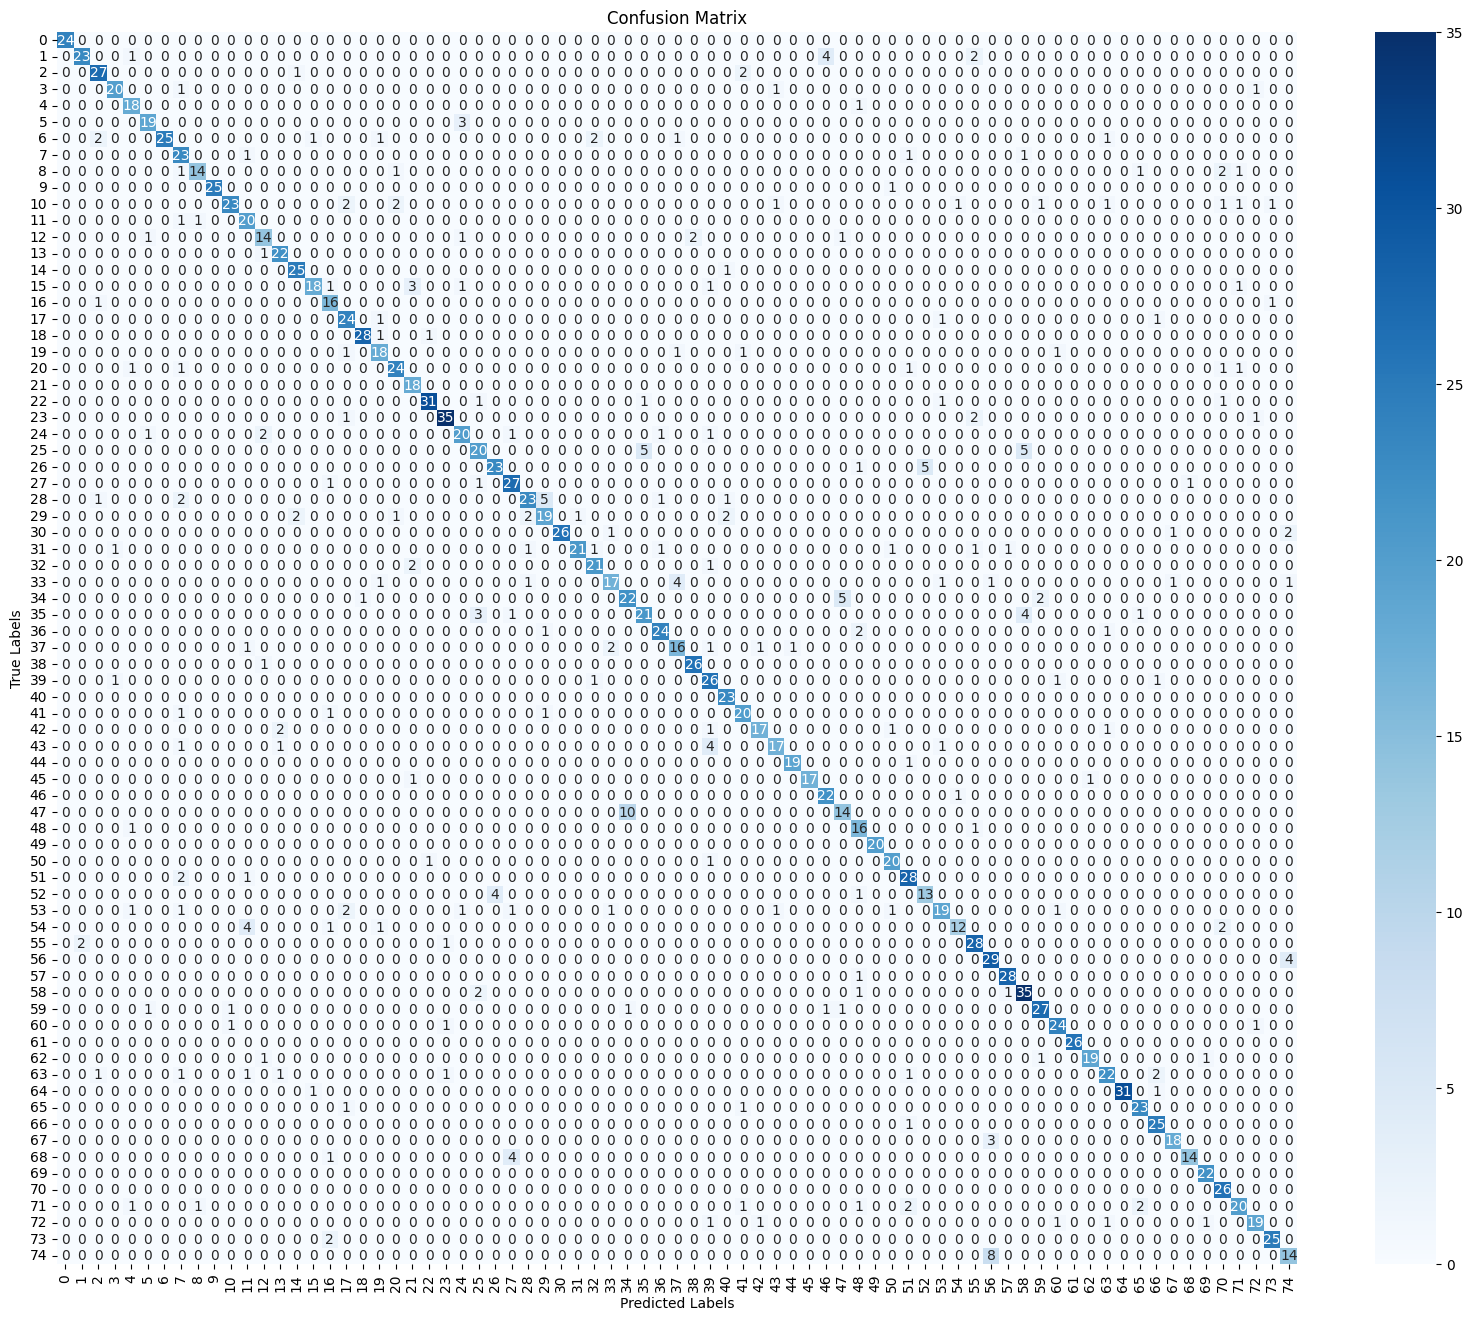

In [26]:
# Convertir las predicciones a clases
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas desde el dataset de validación
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_true_classes = np.argmax(y_true)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Dibujar la matriz de confusión
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
from sklearn.metrics import classification_report

# Generar el informe de clasificación
report = classification_report(y_true, y_pred_classes, target_names=y_train_index)
print(report)

                           precision    recall  f1-score   support

                    88 AN       1.00      1.00      1.00        24
              ADMIRAL RED       0.92      0.77      0.84        30
                   ADONIS       0.84      0.90      0.87        30
AFRICAN GIANT SWALLOWTAIL       0.91      0.87      0.89        23
           AMERICAN SNOOT       0.78      0.95      0.86        19
                  APPOLLO       0.86      0.86      0.86        22
                    ATALA       1.00      0.76      0.86        33
        AWL BANDED COMMON       0.66      0.88      0.75        26
              BANDED GOLD       0.88      0.70      0.78        20
 BANDED HELICONIAN ORANGE       1.00      0.96      0.98        26
           BANDED PEACOCK       0.92      0.68      0.78        34
       BARRED FLASHER TWO       0.71      0.91      0.80        22
            BECKERS WHITE       0.74      0.74      0.74        19
          BIRDWING CAIRNS       0.85      0.96      0.90     

In [16]:
model.save('Modelo Final/ResnetModel.h5')

In [24]:
model.save_weights('Modelo Final/ResnetModel.weights.h5')